生成了 32 个测试用例
测试用例 4:
风向角: 180.0°
峰值位置: phi_idx = 2


/var/folders/2q/l5wskg9d0zn78b3n0tmsjgc40000gn/T/ipykernel_88754/1360322054.py:131: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2q/l5wskg9d0zn78b3n0tmsjgc40000gn/T/ipykernel_88754/1360322054.py:131: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2q/l5wskg9d0zn78b3n0tmsjgc40000gn/T/ipykernel_88754/1360322054.py:131: UserWarning: Glyph 35282 (\N{CJK UNIFIED IDEOGRAPH-89D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2q/l5wskg9d0zn78b3n0tmsjgc40000gn/T/ipykernel_88754/1360322054.py:131: UserWarning: Glyph 27874 (\N{CJK UNIFIED IDEOGRAPH-6CE2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2q/l5wskg9d0zn78b3n0tmsjgc40000gn/T/ipykernel_88754/1360322054.py:131: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/2q

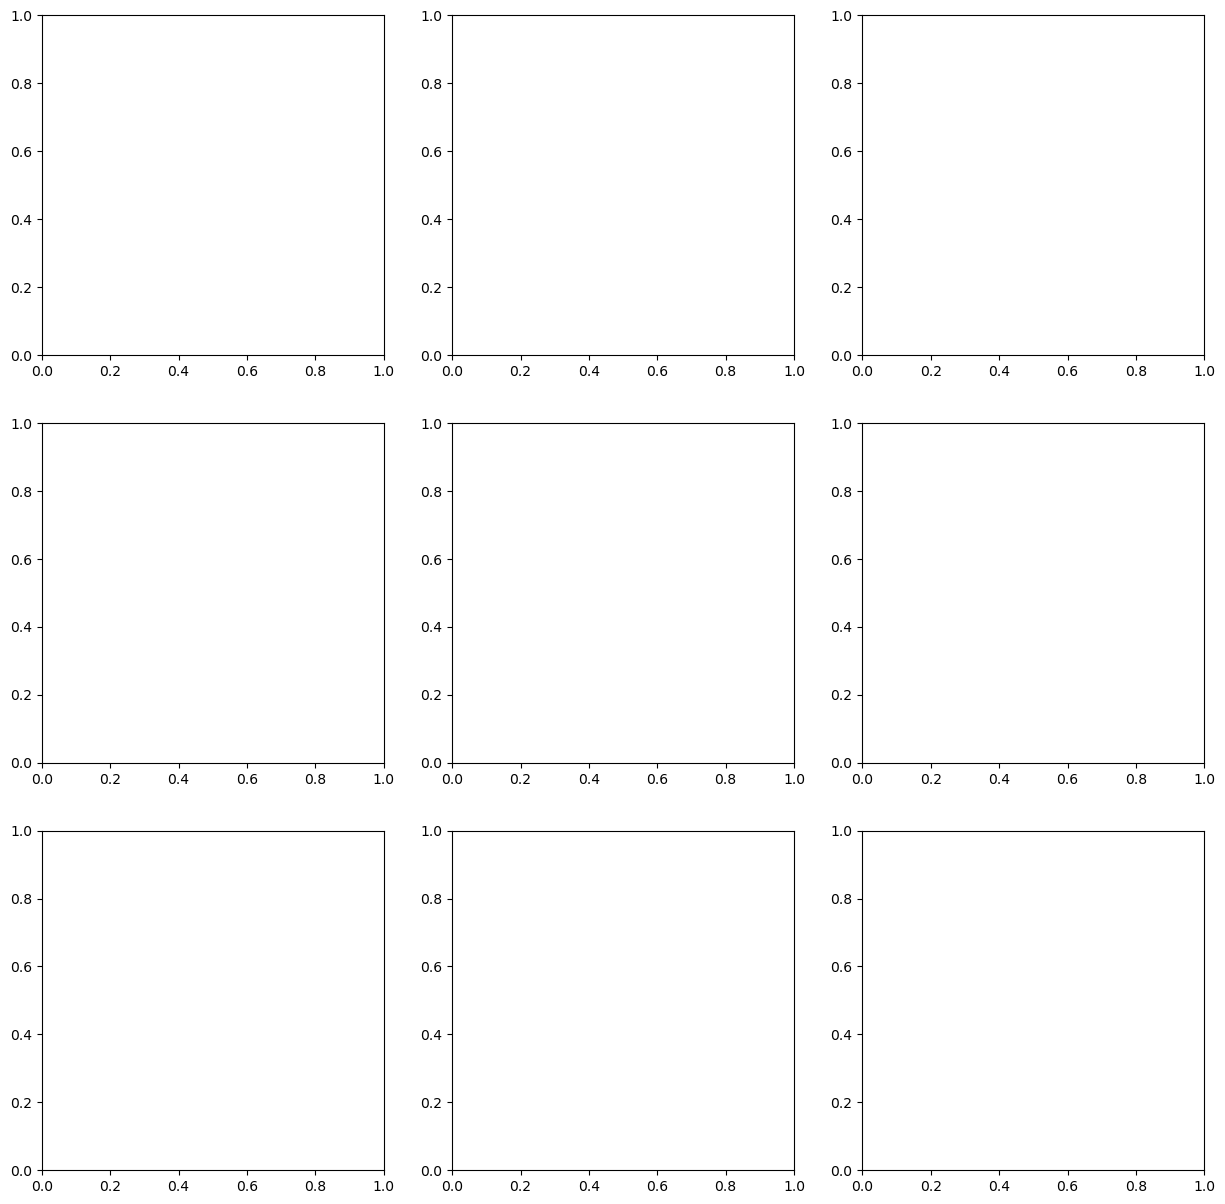

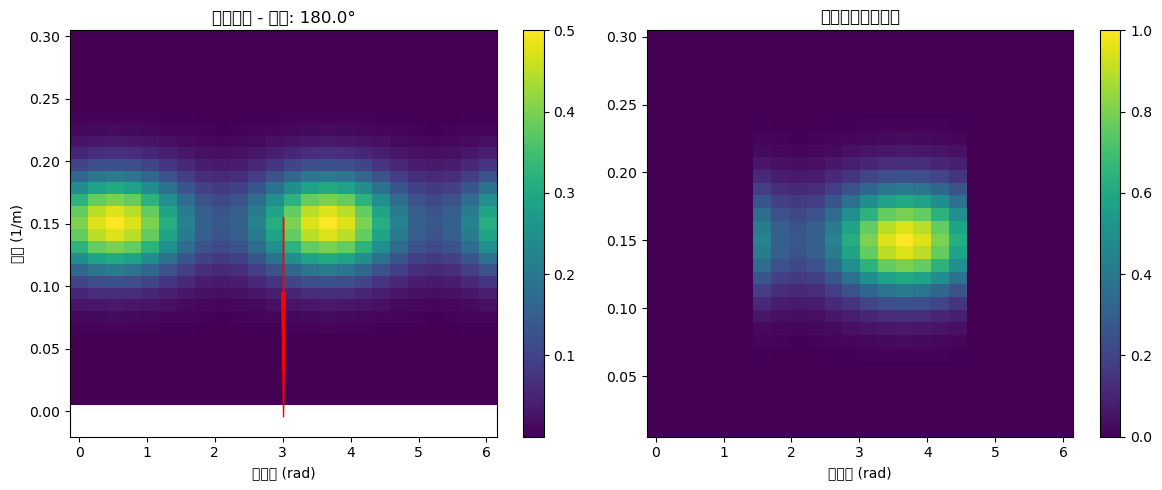

测试成功！


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from waveutils.ambiguity_removal import remove_ambiguity_accord_wind

def generate_test_data():
    """生成测试数据：固定的网格和不同峰值位置的高斯分布波谱"""
    # 定义维度
    nk = 32  # 波数维度
    nphi = 24  # 方位角维度
    
    # 创建递增的波数和方位角网格
    k_values = np.linspace(0.01, 0.3, nk)
    phi_values = np.linspace(0, 2*np.pi - 2*np.pi/nphi, nphi)
    
    # 创建2D网格
    phi_mesh, k_mesh = np.meshgrid(phi_values, k_values)
    
    return k_mesh, phi_mesh

def create_gaussian_spectrum(k_mesh, phi_mesh, peak_k_idx, peak_phi_idx, sigma_k=3, sigma_phi=3):
    """创建高斯分布的波谱，峰值在指定位置"""
    nk, nphi = k_mesh.shape
    k_idx, phi_idx = np.meshgrid(np.arange(nk), np.arange(nphi), indexing='ij')
    
    # 创建高斯分布（考虑角度的周期性）
    spec = np.exp(-((k_idx - peak_k_idx)**2 / (2 * sigma_k**2) + 
                    (np.minimum((phi_idx - peak_phi_idx) % nphi, (peak_phi_idx - phi_idx) % nphi)**2) / 
                    (2 * sigma_phi**2)))
    
    spec = (spec + np.roll(spec, spec.shape[1]//2,axis=1))/ 2
    return spec

def run_test_cases():
    """运行多个测试用例并可视化结果"""
    k_mesh, phi_mesh = generate_test_data()
    swim_heading = 0
    
    # 准备不同方向的风向量
    wind_angles = np.array([0, 45, 90, 135, 180, 225, 270, 315]) * np.pi/180
    wind_speed = 10.0  # m/s
    
    u10_values = wind_speed * np.sin(wind_angles)
    v10_values = wind_speed * np.cos(wind_angles)
    
    # 创建一个3x3的图表布局用于可视化
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    
    # 原始波谱在中央位置
    peak_k_idx = 15  # 在波数维度的峰值位置
    peak_phi_idxs = [2, 8, 14, 20]  # 在方位角维度的不同峰值位置
    
    # 测试用例
    test_cases = []
    
    # 对每个峰值位置生成测试数据
    for peak_phi_idx in peak_phi_idxs:
        swim_spec = create_gaussian_spectrum(k_mesh, phi_mesh, peak_k_idx, peak_phi_idx)
        
        for angle_idx, (u10, v10) in enumerate(zip(u10_values, v10_values)):
            test_cases.append({
                'swim_spec': swim_spec.copy(),
                'swim_k_spectra': k_mesh.copy(),
                'swim_phi_spectra': phi_mesh.copy(),
                'swim_heading': swim_heading,
                'u10': u10,
                'v10': v10,
                'angle_deg': wind_angles[angle_idx] * 180/np.pi,
                'peak_phi_idx': peak_phi_idx
            })
    
    print(f"生成了 {len(test_cases)} 个测试用例")
    
    # 返回测试用例
    return test_cases

# 主测试代码
test_cases = run_test_cases()

# 示例：运行第一个测试用例
def run_single_test(test_case):
    """运行单个测试并返回结果"""
    result = remove_ambiguity_accord_wind(
        swim_spec=test_case['swim_spec'],
        swim_k_spectra=test_case['swim_k_spectra'],
        swim_phi_spectra=test_case['swim_phi_spectra'],
        swim_heading=test_case['swim_heading'],
        u10=test_case['u10'],
        v10=test_case['v10']
    )
    return result

# 测试示例
test_idx = 4
print(f"测试用例 {test_idx}:")
print(f"风向角: {test_cases[test_idx]['angle_deg']}°")
print(f"峰值位置: phi_idx = {test_cases[test_idx]['peak_phi_idx']}")


# 可视化原始波谱与处理后的波谱比较
def visualize_comparison(test_case, result):
    """可视化原始波谱与处理后的波谱比较"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # 原始波谱
    im1 = ax1.pcolormesh(test_case['swim_phi_spectra'], test_case['swim_k_spectra'], 
                        test_case['swim_spec'], shading='auto')
    ax1.set_title(f"原始波谱 - 风向: {test_case['angle_deg']}°")
    ax1.set_xlabel("方位角 (rad)")
    ax1.set_ylabel("波数 (1/m)")
    fig.colorbar(im1, ax=ax1)
    
    # 处理后的波谱
    im2 = ax2.pcolormesh(test_case['swim_phi_spectra'], test_case['swim_k_spectra'], 
                        result, shading='auto')
    ax2.set_title("消除歧义后的波谱")
    ax2.set_xlabel("方位角 (rad)")
    fig.colorbar(im2, ax=ax2)
    
    # 显示风向箭头
    wind_dir_rad = np.arctan2(test_case['u10'], test_case['v10'])
    midpoint_x = np.mean(ax1.get_xlim())
    midpoint_y = np.mean(ax1.get_ylim())
    arrow_length = 0.2 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])
    
    ax1.arrow(midpoint_x, midpoint_y, 
             arrow_length * np.sin(wind_dir_rad), 
             arrow_length * np.cos(wind_dir_rad),
             head_width=0.05, head_length=0.1, fc='r', ec='r')
    
    plt.tight_layout()
    plt.show()

# 执行测试并查看结果
try:
    result = run_single_test(test_cases[test_idx])
    visualize_comparison(test_cases[test_idx], result)
    print("测试成功！")
except Exception as e:
    print(f"测试失败: {e}")


In [1]:
sar_da_dir = "/home/shihaozou/scratch/data/sentinel-1 L2 OCN/sar_covered_PAPA_2022.nc"
papa_da_dir = "/home/shihaozou/scratch/data/ocean_station_papa/PAPA_MEM2D.nc"

sar_da = xr.open_dataset(sar_da_dir)
papa_da = xr.open_dataset(papa_da_dir)
nearest_time_index = np.abs(papa_da['waveTime'] - moment).argmin()
papa_da_nearest = papa_da.isel(waveTime=nearest_time_index)

nearest_time_index = np.abs(sar_da['time'] - moment).argmin()
sar_da_nearest = sar_da.isel(time=nearest_time_index)
sar_moment = sar_da_nearest['time'].values
sar_spec = sar_da_nearest['oswQualityCrossSpectraIm'].values[0, 0, :, :]
sar_K = sar_da_nearest['oswK'].values
sar_PHI = sar_da_nearest['oswPhi'].values

sar_K_mesh, sar_PHI_mesh = np.meshgrid(sar_K, sar_PHI)

sar_spec, sar_K_mesh, sar_PHI_mesh = sar_spec.T, sar_K_mesh.T, sar_PHI_mesh.T

sar_spec2swim = waveutils.interpolate_wave_polar(sar_spec, sar_K, sar_PHI*np.pi/180, swim_K, swim_PHI)


sar_spec2swim[sar_spec2swim > 0] = 0
sar_spec2swim *= -1
_,  partition_index_sar = waveutils.partition_waves_polar(K_mesh, PHI_mesh, sar_spec2swim)
plt.figure()
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, partition_index, alpha=0.8, cmap='Reds')
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, partition_index_sar, alpha=0.3, cmap='Greens')
plt.title('Partition Index Comparison')
plt.xlabel('PHI (degree)')
plt.ylabel('wavenumber ($m^{-1}$)')


res = waveutils._kernel_based_partition_representation(sar_spec2swim, partition_index_sar)
plt.figure()
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, res)
plt.colorbar()


NameError: name 'xr' is not defined

In [ ]:
nearest_time_index

In [ ]:
plt.plot(sar_K)

In [ ]:
dphi = 2*np.pi / partition_index.shape[1]
    
rolling_column = int(np.round(np.pi / dphi))

partition_index_rolled = np.roll(partition_index, rolling_column, axis=1)

plt.figure()
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, partition_index, alpha=0.8, cmap='Reds')
plt.pcolormesh(PHI_mesh*180/np.pi, K_mesh, partition_index_rolled, alpha=0.3, cmap='Greens')
plt.title('Partition Index Comparison')